<a href="https://colab.research.google.com/github/josemoti1999/data_analysis_argoid/blob/master/argoid_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 1

In this notebook I would be giving Exploratory Data Analysis on [this](https://drive.google.com/file/d/1Ce_ta6Ri9o3mi8g5_lr6oEe9uBFNt74Z/view?usp=sharing) dataset. For most part of the notebook feature engineering, data cleaning and insight gaining was done. 

For clustering/ segmenting the UserId see the final part of notebook. **data_final.csv** gives the 6 classes to which UserId was divided using K-Means algorithm. See the final section for more details.

Change to root folder here if you are running this notebook.

In [0]:
cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


##Importing libraries

In [0]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn import preprocessing

##Cleaning Data


In [0]:
df = pd.read_csv('transaction_data.csv')
print(df.shape)
df.describe()

(1083818, 8)


,UserId,TransactionId,ItemCode,NumberOfItemsPurchased,CostPerItem
count,1.083818e+06,1.083818e+06,1.083818e+06,1.083818e+06,1.083818e+06
mean,2.410162e+05,6.159417e+06,6.582687e+05,2.865675e+01,9.498798e+00
std,1.423364e+05,1.476341e+05,4.526314e+05,6.542432e+02,2.308139e+03
min,-1.000000e+00,5.900015e+06,-1.000000e+00,-2.429850e+05,-1.526564e+04
25%,2.593920e+05,6.026856e+06,4.609080e+05,3.000000e+00,1.730000e+00
50%,3.020220e+05,6.166611e+06,4.752930e+05,9.000000e+00,2.880000e+00
75%,3.413550e+05,6.289569e+06,4.889430e+05,3.000000e+01,5.700000e+00
max,3.840270e+05,6.397457e+06,1.894494e+06,2.429850e+05,1.696285e+06


ItemCode and UserID have -1 values signifying unknown UserIds and ItemCodes.

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083818 entries, 0 to 1083817
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   UserId                  1083818 non-null  int64  
 1   TransactionId           1083818 non-null  int64  
 2   TransactionTime         1083818 non-null  object 
 3   ItemCode                1083818 non-null  int64  
 4   ItemDescription         1080910 non-null  object 
 5   NumberOfItemsPurchased  1083818 non-null  int64  
 6   CostPerItem             1083818 non-null  float64
 7   Country                 1083818 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 66.2+ MB


CostPerItem comes ==0

In [0]:
temp = df.sort_values(['TransactionId'])
temp = temp[temp['CostPerItem']==0]

temp = temp.groupby('ItemDescription').count()['CostPerItem'].reset_index().sort_values(by='CostPerItem',ascending=False).reset_index(drop=True )
print(temp['CostPerItem'].sum())
temp.head(10).style.background_gradient(cmap='Reds')

2122


,ItemDescription,CostPerItem
0,check,318
1,?,94
2,damages,90
3,damaged,86
4,found,50
5,sold as set on dotcom,40
6,adjustment,32
7,Damaged,28
8,"Unsaleable, destroyed.",18
9,FRENCH BLUE METAL DOOR SIGN 1,18


Cost comes < 0

In [0]:
temp = df.sort_values(['TransactionId'])
temp = temp[temp['CostPerItem']<0]
temp

There are no rows where NumberOfItemsPurchased = 0. There are several cases when NumberOfItemsPurchased comes < 0. These may be the products getting returned when a customer arrives the next time or may be discounts as well and thus are not removed.

In [0]:
temp = df.sort_values(['TransactionId'])
temp = temp[temp['NumberOfItemsPurchased']<=0]
print(temp.shape)

temp = temp.groupby('ItemDescription').count()['NumberOfItemsPurchased'].reset_index().sort_values(by='NumberOfItemsPurchased',ascending=False).reset_index(drop=True )
temp.head(10).style.background_gradient(cmap='Reds')

(21248, 8)


,ItemDescription,NumberOfItemsPurchased
0,Manual,488
1,REGENCY CAKESTAND 3 TIER,362
2,POSTAGE,252
3,check,240
4,JAM MAKING SET WITH JARS,174
5,Discount,154
6,SET OF 3 CAKE TINS PANTRY DESIGN,148
7,SAMPLES,122
8,STRAWBERRY CERAMIC TRINKET BOX,110
9,ROSES REGENCY TEACUP AND SAUCER,108


The rows with CostPerItem and NumberOfItemsPurchased==0 are removed.


In [0]:
df_new = df[df['CostPerItem']!=0].reset_index(drop=True)
df_new = df_new[df_new['NumberOfItemsPurchased']!=0].reset_index(drop=True)

In [0]:
df=df_new

In [0]:
df.shape

(1078788, 8)

In [0]:
df.info()   

All NaNs were removed. These data mostly might be mistakes happened while billing. Now we have a clean data with us.

In [0]:
df.sort_values(by=['TransactionId', 'ItemCode']).head(10)

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
916384,374850,5900015,Mon Feb 12 04:26:00 IST 2018,456330,GLASS STAR FROSTED T-LIGHT HOLDER,18,5.87,United Kingdom
1019560,374850,5900015,Mon Feb 12 04:26:00 IST 2018,456330,GLASS STAR FROSTED T-LIGHT HOLDER,18,5.87,United Kingdom
54921,374850,5900015,Mon Feb 12 04:26:00 IST 2018,477792,SET 7 BABUSHKA NESTING BOXES,6,10.56,United Kingdom
505871,374850,5900015,Mon Feb 12 04:26:00 IST 2018,477792,SET 7 BABUSHKA NESTING BOXES,6,10.56,United Kingdom
321744,374850,5900015,Mon Feb 12 04:26:00 IST 2018,1492113,WHITE METAL LANTERN,18,4.68,United Kingdom
632235,374850,5900015,Mon Feb 12 04:26:00 IST 2018,1492113,WHITE METAL LANTERN,18,4.68,United Kingdom
410345,374850,5900015,Mon Feb 12 04:26:00 IST 2018,1764609,RED WOOLLY HOTTIE WHITE HEART.,18,4.68,United Kingdom
526312,374850,5900015,Mon Feb 12 04:26:00 IST 2018,1764609,KNITTED UNION FLAG HOT WATER BOTTLE,18,4.68,United Kingdom
535851,374850,5900015,Mon Feb 12 04:26:00 IST 2018,1764609,KNITTED UNION FLAG HOT WATER BOTTLE,18,4.68,United Kingdom
914716,374850,5900015,Mon Feb 12 04:26:00 IST 2018,1764609,RED WOOLLY HOTTIE WHITE HEART.,18,4.68,United Kingdom


There are duplicates of every row and these are to be removed. 

In [0]:
df_new=df.drop_duplicates(keep='first').reset_index(drop=True)
print(df_new.shape)
print(temp[df_new.duplicated(keep='first')].shape)    #No more duplicate rows

(534062, 8)
(0, 2)


In [0]:
df=df_new

The following are the cases when ItemCode becomes -1

In [0]:
temp = df.sort_values(['TransactionId'])
temp = temp[temp['ItemCode']==-1]

temp = temp.groupby('ItemDescription').count()['ItemCode'].reset_index().sort_values(by='ItemCode',ascending=False).reset_index(drop=True )
temp.style.background_gradient(cmap='Reds')

,ItemDescription,ItemCode
0,POSTAGE,1252
1,DOTCOM POSTAGE,707
2,Manual,561
3,Discount,77
4,SAMPLES,62
5,Bank Charges,37
6,AMAZON FEE,34
7,CRUK Commission,16
8,GIRLS PARTY BAG,13
9,BOYS PARTY BAG,11


These are the transactions made by e-commerce the the sale of items not in the database and the discounts of items as well.

When UserId is -1 we consider a separate user for each transaction by giving the UserId as negative of TransactionId. 

In [0]:
df.loc[df['UserId']==-1, 'mask'] = -1 
df.loc[df['UserId']!=-1, 'mask'] = 0
df['UserId'] = df['TransactionId']*df['mask']+df['UserId']

In [0]:
df = df.drop(['mask'], axis=1)

In [0]:
cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [0]:
df.to_csv('/content/drive/My Drive/Kaggle/cleaned_data.csv', index=False)

##Data Analysis

In [0]:
df=pd.read_csv('cleaned_data.csv')
df.shape

(534062, 8)

###Users Country Analysis

In [0]:
temp = df.groupby(['UserId'])['Country'].unique()
temp = temp.to_frame().reset_index()
temp['Country'] = temp['Country'].apply(lambda x: str(x))
temp = temp.groupby(['Country'])['UserId'].count().reset_index().sort_values(by='UserId',ascending=False).reset_index(drop=True )

cm = sns.light_palette("green", as_cmap=True)
temp.style.background_gradient(cmap=cm)

,Country,UserId
0,['United Kingdom'],5488
1,['Germany'],95
2,['France'],90
3,['EIRE'],44
4,['Spain'],29
5,['Switzerland'],22
6,['Belgium'],22
7,['Portugal'],20
8,['Italy'],15
9,['Hong Kong'],15


8 users have multiple countries coming under them. They must have changed the nationalities in between. So it is just 8 guys I am considering the first country in the list as their real country.

In [0]:
temp = df.groupby(['UserId'])['Country'].unique()
temp = temp.to_frame().reset_index()
temp['Country'] = temp['Country'].apply(lambda x: list(x)[0])
temp = temp.groupby(['Country'])['UserId'].count().reset_index().sort_values(by='UserId',ascending=False).reset_index(drop=True )

cm = sns.light_palette("green", as_cmap=True)
temp.style.background_gradient(cmap=cm)

,Country,UserId
0,United Kingdom,5488
1,Germany,95
2,France,90
3,EIRE,44
4,Spain,30
5,Belgium,23
6,Switzerland,23
7,Portugal,20
8,Italy,15
9,Hong Kong,15


In [0]:
temp['UserId'].sum()

5983

5983 unique customers recognized from over 38 countries.

In [0]:
fig = go.Figure(go.Funnelarea(
    text = temp.Country,
    values = temp.UserId,
    title = {'position':'top center', 'text':'Users per country'}
))
fig.show()

In [0]:
fig = go.Figure(go.Funnelarea(
    text = temp[1:].Country,
    values = temp[1:].UserId,
    title = {'position':'top center', 'text':'Users per countries except UK'}
))
fig.show()

###Valid customers Analysis

In [0]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534062 entries, 0 to 534061
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   UserId                  534062 non-null  float64
 1   TransactionId           534062 non-null  int64  
 2   TransactionTime         534062 non-null  object 
 3   ItemCode                534062 non-null  int64  
 4   ItemDescription         534062 non-null  object 
 5   NumberOfItemsPurchased  534062 non-null  int64  
 6   CostPerItem             534062 non-null  float64
 7   Country                 534062 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 32.6+ MB


In [0]:
df['TotalCost'] = df['NumberOfItemsPurchased']*df['CostPerItem']

In [0]:
df.shape

(534062, 9)

With valid UserIds. Invalid users are not considered.

In [0]:
temp = df[df['UserId']>0][['UserId', 'TransactionId', 'TotalCost', 'Country', 'ItemDescription', 
                           'NumberOfItemsPurchased']]
temp = temp.sort_values(by=["UserId", 'TransactionId', 'TotalCost']).reset_index(drop=True)
print(temp.shape)
temp.head(10)

(401529, 6)


,UserId,TransactionId,TotalCost,Country,ItemDescription,NumberOfItemsPurchased
0,259266.0,5955741,320608.80,United Kingdom,MEDIUM CERAMIC TOP STORAGE JAR,222645
1,259266.0,5955763,-320608.80,United Kingdom,MEDIUM CERAMIC TOP STORAGE JAR,-222645
2,259287.0,5913886,52.20,Iceland,FOUR HOOK WHITE LOVEBIRDS,18
3,259287.0,5913886,61.56,Iceland,SET/3 DECOUPAGE STACKING TINS,9
4,259287.0,5913886,62.16,Iceland,ALARM CLOCK BAKELIKE GREEN,12
5,259287.0,5913886,62.16,Iceland,ALARM CLOCK BAKELIKE ORANGE,12
6,259287.0,5913886,62.16,Iceland,ALARM CLOCK BAKELIKE RED,12
7,259287.0,5913886,62.16,Iceland,ALARM CLOCK BAKELIKE PINK,12
8,259287.0,5913886,62.16,Iceland,ALARM CLOCK BAKELIKE CHOCOLATE,12
9,259287.0,5913886,62.28,Iceland,RED DRAWER KNOB ACRYLIC EDWARDIAN,36


In [0]:
grouped = temp.groupby(by='UserId')
new_df = pd.DataFrame()
new_df['Country'] = grouped['Country'].unique()
new_df['TotalCost'] = grouped['TotalCost'].sum()
new_df['NumberOfTransactions'] = grouped['TransactionId'].unique()
new_df = new_df.reset_index()

In [0]:
new_df[new_df['Country'].apply(lambda x:len(x))!=1]

In [0]:
new_df['Country'] = new_df['Country'].apply(lambda x:x[0])
new_df['NumberOfTransactions'] = new_df['NumberOfTransactions'].apply(lambda x:x.shape[0])

In [0]:
new_df.head()

,UserId,Country,TotalCost,NumberOfTransactions
0,259266.0,United Kingdom,0.00,2
1,259287.0,Iceland,17879.70,7
2,259308.0,Finland,7481.52,4
3,259329.0,Italy,7285.92,1
4,259350.0,Norway,1387.20,1


In [0]:
new_df = new_df.sort_values(by='TotalCost', ascending=False)[1:].reset_index(drop=True)

In [0]:
new_df.shape

(4370, 4)

Only 4370 clear valid users. There were 5983 initially consider -1 UserId. 

In [0]:
temp=new_df.reset_index()
temp = temp.groupby(['Country'])['UserId'].count().reset_index().sort_values(by='UserId',ascending=False).reset_index(drop=True )
cm = sns.light_palette("green", as_cmap=True)
temp.style.background_gradient(cmap=cm)

,Country,UserId
0,United Kingdom,3948
1,Germany,95
2,France,87
3,Spain,29
4,Belgium,24
5,Switzerland,20
6,Portugal,19
7,Italy,15
8,Finland,12
9,Norway,10


Valid Users considering top 5. 

In [0]:
l1 = ['Germany', 'France', 'Spain', 'Belgium', 'Switzerland', 'Rest']
l2 = ['United Kingdom', 'Germany', 'France', 'Spain', 'Belgium', 'Switzerland']

In [0]:
new_df.head(5)

,UserId,Country,TotalCost,NumberOfTransactions
0,307566.0,Netherlands,1160233.53,76
1,380142.0,United Kingdom,1062868.20,62
2,366450.0,United Kingdom,776628.15,55
3,313131.0,EIRE,549571.44,248
4,260715.0,Australia,513411.45,26


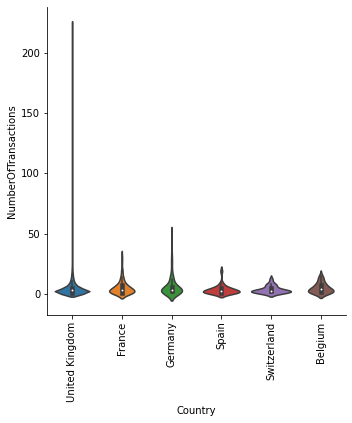

In [0]:
sns.catplot(x='Country', y='NumberOfTransactions', kind='violin', 
            data=new_df[new_df['Country'].apply(lambda x:x in l2)]).set_xticklabels(rotation=90)

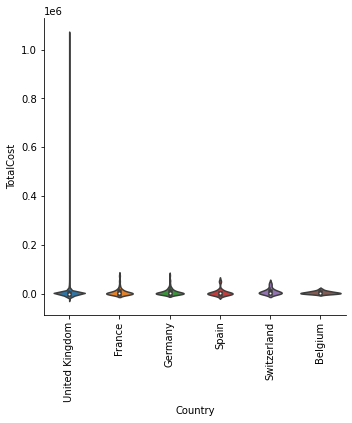

In [0]:
sns.catplot(x='Country', y='TotalCost', kind='violin', 
            data=new_df[new_df['Country'].apply(lambda x:x in l2)]).set_xticklabels(rotation=90)

In [0]:
new_df.head()

,UserId,Country,TotalCost,NumberOfTransactions
0,307566.0,Netherlands,1160233.53,76
1,380142.0,United Kingdom,1062868.20,62
2,366450.0,United Kingdom,776628.15,55
3,313131.0,EIRE,549571.44,248
4,260715.0,Australia,513411.45,26


In [0]:
new_df['Country_split']=new_df['Country'].apply(lambda x:'Not UK' if x!='United Kingdom' else x)

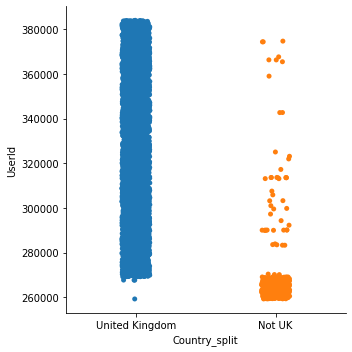

In [0]:
sns.catplot(x='Country_split', y='UserId', 
            order=['United Kingdom', 'Not UK'],
            data=new_df)

In [0]:
new_df.describe()

,UserId,TotalCost,NumberOfTransactions
count,4370.000000,4.370000e+03,4370.000000
mean,321310.514416,7.859528e+03,5.076659
std,36169.287896,3.410194e+04,9.333393
min,259266.000000,-1.775079e+04,1.000000
25%,290099.250000,1.212082e+03,1.000000
50%,321342.000000,2.673285e+03,3.000000
75%,352353.750000,6.676267e+03,5.000000
max,384027.000000,1.160234e+06,248.000000


In [0]:
new_df = new_df.sort_values(by='UserId').reset_index(drop=True)

In [0]:
pd.set_option('max_r', 5000)

In [0]:
new_df['Frequency']=pd.cut(new_df['NumberOfTransactions'], bins=[0,2,300], labels=['Not Frequent', 'Frequent'])
new_df['Spending']=pd.cut(new_df['TotalCost'], bins=[-1.775080e+04,2.673285e+03,1.160334e+06], labels=['Low', 'High'])

In [0]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4370 entries, 0 to 4369
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   UserId                4370 non-null   float64 
 1   Country               4370 non-null   object  
 2   TotalCost             4370 non-null   float64 
 3   NumberOfTransactions  4370 non-null   int64   
 4   Country_split         4370 non-null   object  
 5   Frequency             4370 non-null   category
 6   Spending              4370 non-null   category
dtypes: category(2), float64(2), int64(1), object(2)
memory usage: 179.6+ KB


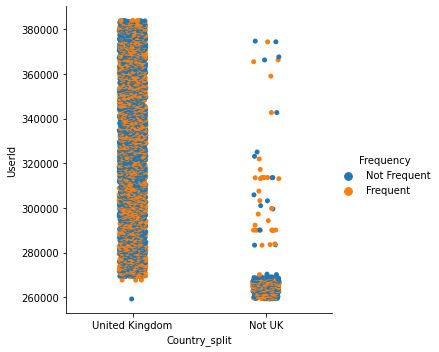

In [0]:
sns.catplot(x='Country_split', y='UserId', hue='Frequency', data=new_df)

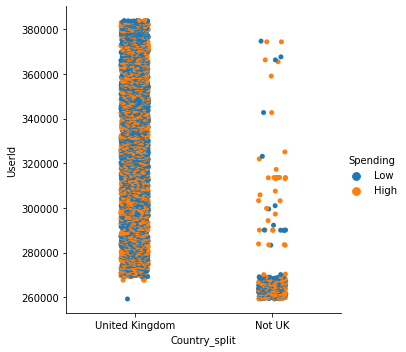

In [0]:
sns.catplot(x='Country_split', y='UserId', hue='Spending', data=new_df)

No clear distinctions between frequency of transactions/ spending amount with that of person living in UK or not.

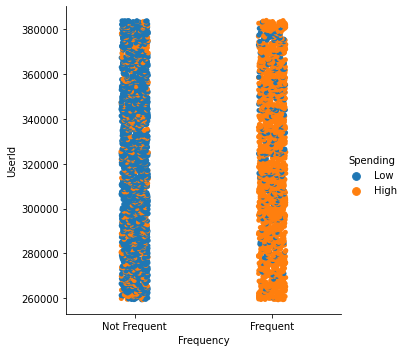

In [0]:
sns.catplot(x='Frequency', y='UserId', hue='Spending', data=new_df)

Frequent users are high spenders while non-frequent users are low spenders

In [0]:
new_df.to_csv('cleaned_data_2.csv', index=False)

**cleaned_data_2** has data grouped by UserId.

###Month Day Analysis 

In [0]:
df2 = pd.read_csv('/content/drive/My Drive/Kaggle/cleaned_data.csv')
print(df2.shape)
df2.head()

(534062, 8)


,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166.0,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701.0,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099.0,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478.0,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-6143226.0,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom


In [0]:
df2[df2['ItemCode']!=-1]['ItemCode'].unique().shape

(3305,)

In [0]:
df2[df2['ItemCode']!=-1]['ItemDescription'].unique().shape

(4030,)

3305 VALID ItemCodes (not including -1). 4030 different ItemDescription given for these 3305 VALID ItemCodes.

In [0]:
df2['TotalCost'] = df2['NumberOfItemsPurchased']*df2['CostPerItem']
df2.head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,TotalCost
0,278166.0,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom,70.38
1,337701.0,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom,10.56
2,267099.0,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France,64.80
3,380478.0,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom,5.19
4,-6143226.0,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom,10.20


In [0]:
#grouping by TransactionId

grouped = df2.groupby('TransactionId')
temp = pd.DataFrame()
temp['UserId'] = grouped['UserId'].unique()
temp['TransactionTime'] = grouped['TransactionTime'].unique()
temp['ItemCode'] = grouped['ItemCode'].unique()
temp['Country'] = grouped['Country'].unique()
temp['TotalCost'] = grouped['TotalCost'].sum()

temp['UserId'] = temp['UserId'].apply(lambda x:x[0])
temp['TransactionTime'] = temp['TransactionTime'].apply(lambda x:x[0])
temp['Country'] = temp['Country'].apply(lambda x:x[0])

In [0]:
temp.sort_index(axis=0)
temp.head()

,UserId,TransactionTime,ItemCode,Country,TotalCost
TransactionId,,,,,
5900015,374850.0,Mon Feb 12 04:26:00 IST 2018,"[477792, 1492113, 1764609, 1772526, 1787583, 4...",United Kingdom,576.30
5900026,374850.0,Mon Feb 12 04:28:00 IST 2018,"[475272, 475293]",United Kingdom,92.16
5900037,273987.0,Mon Feb 12 04:34:00 IST 2018,"[1011927, 456834, 456855, 1782459, 477729, 477...",United Kingdom,1155.54
5900048,273987.0,Mon Feb 12 04:34:00 IST 2018,"[481194, 481173, 481152, 482160]",United Kingdom,290.34
5900059,273987.0,Mon Feb 12 04:35:00 IST 2018,[456876],United Kingdom,73.98


In [0]:
df2=temp

For 1 date there was a mislabelling of Feb 2018 to Feb 2028

In [0]:
df2['TransactionTime'] = df2['TransactionTime'].apply(lambda x:x.replace('2028', '2018'))

In [0]:
df2['Time'] = df2['TransactionTime'].apply(lambda x:str(x.split()[3]))
df2['Day'] = df2['TransactionTime'].apply(lambda x:str(x.split()[0]))
df2['Date'] = df2['TransactionTime'].apply(lambda x:str(x.split()[2]))
df2['MonthYear'] = df2['TransactionTime'].apply(lambda x:(str(x.split()[1]) + ' ' + str(x.split()[-1])))

df2.head()

,UserId,TransactionTime,ItemCode,Country,TotalCost,Time,Day,Date,MonthYear
TransactionId,,,,,,,,,
5900015,374850.0,Mon Feb 12 04:26:00 IST 2018,"[477792, 1492113, 1764609, 1772526, 1787583, 4...",United Kingdom,576.30,04:26:00,Mon,12,Feb 2018
5900026,374850.0,Mon Feb 12 04:28:00 IST 2018,"[475272, 475293]",United Kingdom,92.16,04:28:00,Mon,12,Feb 2018
5900037,273987.0,Mon Feb 12 04:34:00 IST 2018,"[1011927, 456834, 456855, 1782459, 477729, 477...",United Kingdom,1155.54,04:34:00,Mon,12,Feb 2018
5900048,273987.0,Mon Feb 12 04:34:00 IST 2018,"[481194, 481173, 481152, 482160]",United Kingdom,290.34,04:34:00,Mon,12,Feb 2018
5900059,273987.0,Mon Feb 12 04:35:00 IST 2018,[456876],United Kingdom,73.98,04:35:00,Mon,12,Feb 2018


In [0]:
df2['Day'].unique()

array(['Mon', 'Tue', 'Wed', 'Fri', 'Sat', 'Sun'], dtype=object)

Data for Thursdays not given.

In [0]:
df2['MonthYear'].unique()

array(['Feb 2018', 'Mar 2018', 'Apr 2018', 'May 2018', 'Jun 2018',
       'Jul 2018', 'Aug 2018', 'Sep 2018', 'Oct 2018', 'Nov 2018',
       'Dec 2018', 'Jan 2019', 'Feb 2019'], dtype=object)

There is a wrong label of Feb2028 is corrected.

In [0]:
df2.drop(columns='TransactionTime', inplace=True)

23798 transactions recorded in total.

In [0]:
temp = df2.sort_values(by='TotalCost', ascending=False)[3:-3]
temp.sort_index(inplace=True)
temp.shape

(23792, 8)

In [0]:
df2=temp
df2.reset_index(inplace=True)
df2.head()

,TransactionId,UserId,ItemCode,Country,TotalCost,Time,Day,Date,MonthYear
0,5900015,374850.0,"[477792, 1492113, 1764609, 1772526, 1787583, 4...",United Kingdom,576.30,04:26:00,Mon,12,Feb 2018
1,5900026,374850.0,"[475272, 475293]",United Kingdom,92.16,04:28:00,Mon,12,Feb 2018
2,5900037,273987.0,"[1011927, 456834, 456855, 1782459, 477729, 477...",United Kingdom,1155.54,04:34:00,Mon,12,Feb 2018
3,5900048,273987.0,"[481194, 481173, 481152, 482160]",United Kingdom,290.34,04:34:00,Mon,12,Feb 2018
4,5900059,273987.0,[456876],United Kingdom,73.98,04:35:00,Mon,12,Feb 2018


In [0]:
df2['Country_split'] = df2['Country'].apply(lambda x:'Not UK' if x!='United Kingdom' else x)

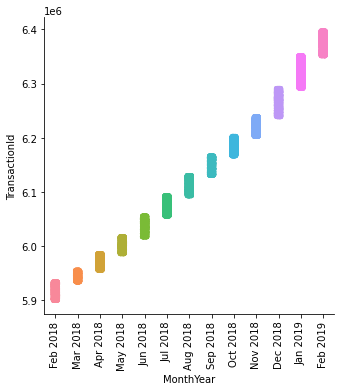

In [0]:
sns.catplot(x='MonthYear', y='TransactionId', data=df2).set_xticklabels(rotation=90)

TransactionId depends on the time of purchase.

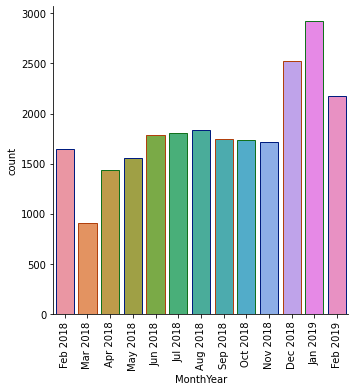

In [0]:
sns.catplot(x='MonthYear', kind='count', data=df2,
            edgecolor=sns.color_palette("dark", 3)).set_xticklabels(rotation=90)

Best sales at the months of December, January, and February.

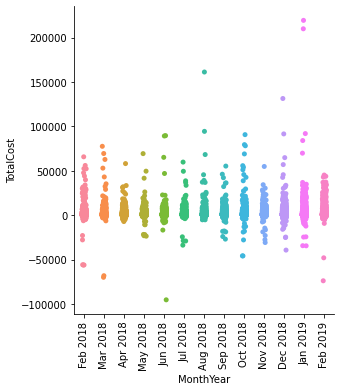

In [0]:
sns.catplot(x='MonthYear',y='TotalCost', data=df2).set_xticklabels(rotation=90)

TotalCost distribution is same across months.

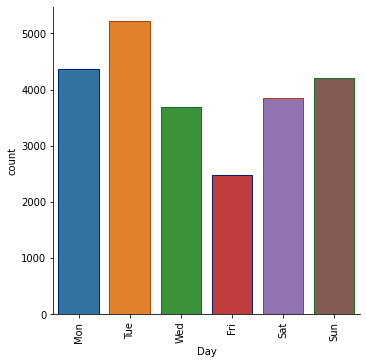

In [0]:
sns.catplot(x='Day', kind='count', data=df2,
            edgecolor=sns.color_palette("dark", 3)).set_xticklabels(rotation=90)

Best sales for Tuesdays, Mondays and Sundays. Least sales at Friday. 

###Time analysis

In [0]:
df2['TimeHour'] = df2['Time'].apply(lambda x:x.split(':')[0])

In [0]:
df2.drop(columns='Time', inplace=True)
df2.head()

,TransactionId,UserId,ItemCode,Country,TotalCost,Day,Date,MonthYear,Country_split,TimeHour
0,5900015,374850.0,"[477792, 1492113, 1764609, 1772526, 1787583, 4...",United Kingdom,576.30,Mon,12,Feb 2018,United Kingdom,04
1,5900026,374850.0,"[475272, 475293]",United Kingdom,92.16,Mon,12,Feb 2018,United Kingdom,04
2,5900037,273987.0,"[1011927, 456834, 456855, 1782459, 477729, 477...",United Kingdom,1155.54,Mon,12,Feb 2018,United Kingdom,04
3,5900048,273987.0,"[481194, 481173, 481152, 482160]",United Kingdom,290.34,Mon,12,Feb 2018,United Kingdom,04
4,5900059,273987.0,[456876],United Kingdom,73.98,Mon,12,Feb 2018,United Kingdom,04


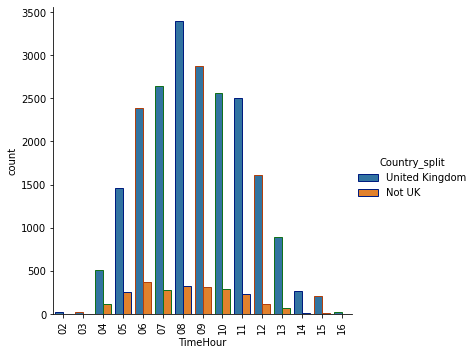

In [0]:
sns.catplot(x='TimeHour', hue='Country_split', kind='count', data=df2,
            edgecolor=sns.color_palette("dark", 3)).set_xticklabels(rotation=90)

Peak hours are from 06 to 12. Peakest hour 08 - 09. These are the most suitable times for advertisements.

In [0]:
df2.to_csv('cleaned_data_3.csv', index=False)

**cleaned_data_3** grouped by TransactionId.

In [0]:
df2 = pd.read_csv('/content/drive/My Drive/Kaggle/cleaned_data_3.csv')
df2.head()

,TransactionId,UserId,ItemCode,Country,TotalCost,Day,Date,MonthYear,Country_split,TimeHour
0,5900015,374850.0,[ 477792 1492113 1764609 1772526 1787583 456330],United Kingdom,576.30,Mon,12,Feb 2018,United Kingdom,4
1,5900026,374850.0,[475272 475293],United Kingdom,92.16,Mon,12,Feb 2018,United Kingdom,4
2,5900037,273987.0,[1011927 456834 456855 1782459 477729 4776...,United Kingdom,1155.54,Mon,12,Feb 2018,United Kingdom,4
3,5900048,273987.0,[481194 481173 481152 482160],United Kingdom,290.34,Mon,12,Feb 2018,United Kingdom,4
4,5900059,273987.0,[456876],United Kingdom,73.98,Mon,12,Feb 2018,United Kingdom,4


###ItemCode analysis

In [460]:
df = pd.read_csv('cleaned_data.csv')
print(df.shape)
df.head()

(534062, 8)


,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166.0,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701.0,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099.0,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478.0,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-6143226.0,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom


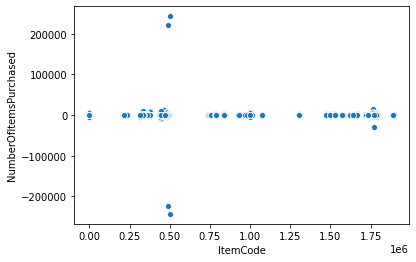

In [461]:
sns.scatterplot(data=df, x='ItemCode', y='NumberOfItemsPurchased')

In [0]:
temp=df.sort_values(by='NumberOfItemsPurchased')
temp=temp[4:-2].reset_index(drop=True)

In [0]:
temp['CountrySplit']=temp['Country'].apply(lambda x:'Not Uk' if x!= 'United Kingdom' else x)
temp=temp.sort_values(by="CostPerItem")
temp=temp[2:-1].reset_index(drop=True)

In [0]:
temp=temp[temp['ItemCode']!=-1].reset_index(drop=True)

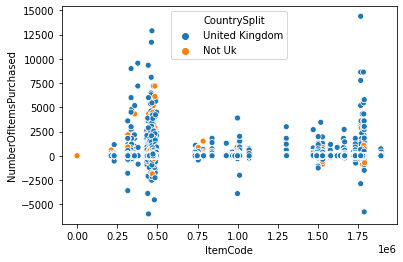

In [465]:
sns.scatterplot(data=temp, x='ItemCode', y='NumberOfItemsPurchased', hue='CountrySplit')

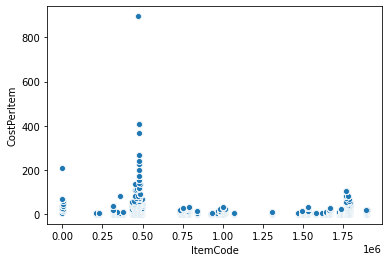

In [466]:
sns.scatterplot(data=temp, x='ItemCode', y='CostPerItem')

In [0]:
df=temp

In [0]:
with open('label_dict.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [0]:
grouped=df.groupby('ItemCode')
temp=grouped['NumberOfItemsPurchased'].sum()
temp=temp.reset_index()
temp['ItemDescription']=temp['ItemCode'].apply(lambda x: b[x][0])

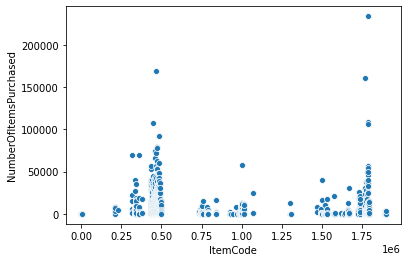

In [471]:
sns.scatterplot(data=temp, x='ItemCode', y='NumberOfItemsPurchased')

Most bought items are

1.JUMBO BAG BAROQUE BLACK WHITE
2.SMALL POPCORN HOLDER
3.WORLD WAR 2 GLIDERS ASSTD DESIGNS
4.ASSRTED COLOUR BIRD ORNAENT


remove high positives and negatives for NumberOfItemsPurchased
remove negatives for CostPerItem
cost changes with time

##Dividing UserIds

In [0]:
df=pd.read_csv('cleaned_data.csv')
df.shape

(534062, 8)

In [0]:
df['TotalCost'] = df['NumberOfItemsPurchased']*df['CostPerItem']

In [0]:
temp = df[df['UserId']>0][['UserId', 'TransactionId', 'TotalCost', 'Country', 'ItemDescription', 
                           'NumberOfItemsPurchased']]
temp = temp.sort_values(by=["UserId", 'TransactionId', 'TotalCost']).reset_index(drop=True)
print(temp.shape)

(401529, 6)


In [0]:
grouped = temp.groupby(by='UserId')
new_df = pd.DataFrame()
new_df['Country'] = grouped['Country'].unique()
new_df['TotalCost'] = grouped['TotalCost'].sum()
new_df['NumberOfTransactions'] = grouped['TransactionId'].unique()
new_df['MaxTransaction']=grouped['TransactionId'].max()
new_df['MinTransaction']=grouped['TransactionId'].min()
new_df = new_df.reset_index()

In [0]:
new_df['Country'] = new_df['Country'].apply(lambda x:x[0])
new_df['NumberOfTransactions'] = new_df['NumberOfTransactions'].apply(lambda x:x.shape[0])

In [0]:
new_df = new_df.sort_values(by='TotalCost', ascending=False)[1:].reset_index(drop=True)

In [0]:
new_df.shape

(4370, 6)

In [0]:
new_df['Country_split']=new_df['Country'].apply(lambda x:'Not UK' if x!='United Kingdom' else x)

In [0]:
new_df = new_df.sort_values(by='UserId').reset_index(drop=True)

In [0]:
new_df['Frequency']=pd.cut(new_df['NumberOfTransactions'], bins=[0,50,8000], labels=['Not Frequent', 'Frequent'])
new_df['Spending']=pd.cut(new_df['TotalCost'], bins=[-1.775080e+04,2.673285e+03,1.160334e+06], labels=['Low', 'High'])

In [0]:
new_df['GapTransaction']=new_df['MaxTransaction']-new_df['MinTransaction']

In [0]:
new_df.head()

,UserId,Country,TotalCost,NumberOfTransactions,MaxTransaction,MinTransaction,Country_split,Frequency,Spending,GapTransaction
0,259266.0,United Kingdom,0.00,2,5955763,5955741,United Kingdom,Not Frequent,Low,22
1,259287.0,Iceland,17879.70,7,6392980,5913886,Not UK,Not Frequent,High,479094
2,259308.0,Finland,7481.52,4,6249892,5932498,Not UK,Not Frequent,High,317394
3,259329.0,Italy,7285.92,1,6353699,6353699,Not UK,Not Frequent,High,0
4,259350.0,Norway,1387.20,1,5973407,5973407,Not UK,Not Frequent,Low,0


#Unsupervised clustering
The only clear pattern that could be found from plots was the UserId difference occuring betweem 'United Kingdom' users and 'Non UK' users. In this section I will be clustering the whole 'UserId' data using the following features.<br/>
1. TotalCost - total amount spent by a user
2. NumberOf Transactions
3. MinTransaction - gives an idea of when first transaction occurred as TransactionId changes with date/time linearly.
4. MaxTransaction - represent time of last transaction
5. GapTransaction - whether a frequent customer 

In [0]:
new_df.to_csv('cleaned_data_4.csv', index=False)

In [0]:
df = pd.read_csv('cleaned_data_4.csv')

In [473]:
df['Is_UK']=df['Country_split'].apply(lambda x:1 if x=='United Kingdom' else 0)
df=df[['UserId',
       'TotalCost', 'NumberOfTransactions', 'MaxTransaction', 'MinTransaction', 'GapTransaction', 'Is_UK']]
df.head()

,UserId,TotalCost,NumberOfTransactions,MaxTransaction,MinTransaction,GapTransaction,Is_UK
0,259266.0,0.00,2,5955763,5955741,22,1
1,259287.0,17879.70,7,6392980,5913886,479094,0
2,259308.0,7481.52,4,6249892,5932498,317394,0
3,259329.0,7285.92,1,6353699,6353699,0,0
4,259350.0,1387.20,1,5973407,5973407,0,0


In [0]:
X = df.iloc[:,1:-1].values
X = preprocessing.scale(X)
wcss =[]
for i in range (1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter =300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

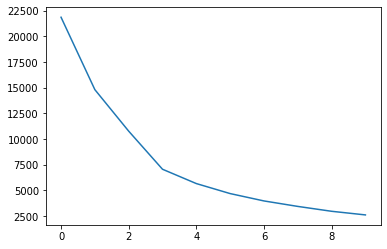

In [475]:
plt.plot(wcss)

Cluster size of 3 is used

In [476]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter =300, n_init = 10, random_state = 0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [477]:
kmeans.labels_

array([2, 0, 0, ..., 1, 0, 1], dtype=int32)

In [478]:
df['cluster']=kmeans.labels_.tolist()
df.head()

,UserId,TotalCost,NumberOfTransactions,MaxTransaction,MinTransaction,GapTransaction,Is_UK,cluster
0,259266.0,0.00,2,5955763,5955741,22,1,2
1,259287.0,17879.70,7,6392980,5913886,479094,0,0
2,259308.0,7481.52,4,6249892,5932498,317394,0,0
3,259329.0,7285.92,1,6353699,6353699,0,0,1
4,259350.0,1387.20,1,5973407,5973407,0,0,2


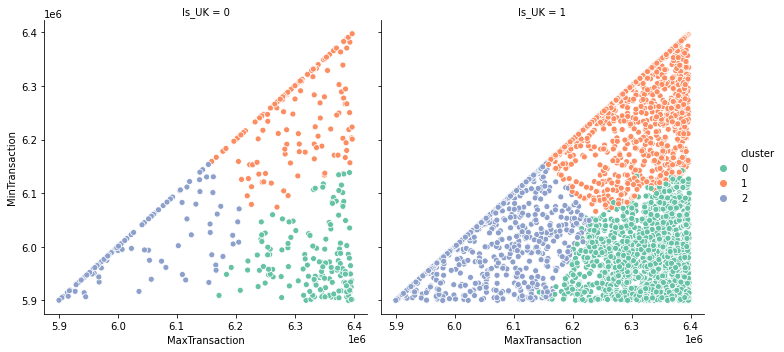

In [481]:
sns.relplot(data=df, x='MaxTransaction', y='MinTransaction', hue='cluster',palette="Set2", col='Is_UK')

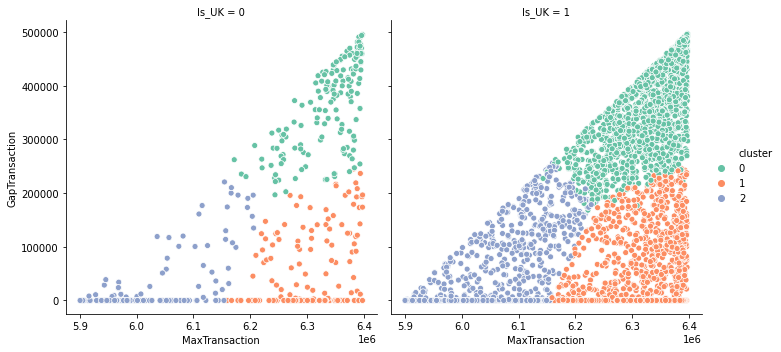

In [482]:
sns.relplot(data=df, x='MaxTransaction', y='GapTransaction', hue='cluster',palette="Set2", col='Is_UK')

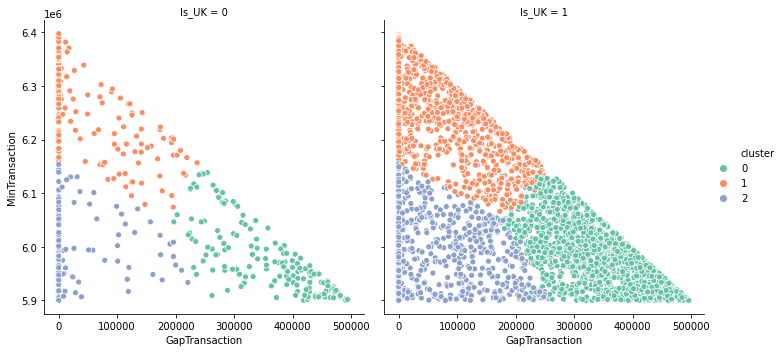

In [483]:
sns.relplot(data=df, x='GapTransaction', y='MinTransaction', hue='cluster',palette="Set2", col='Is_UK')

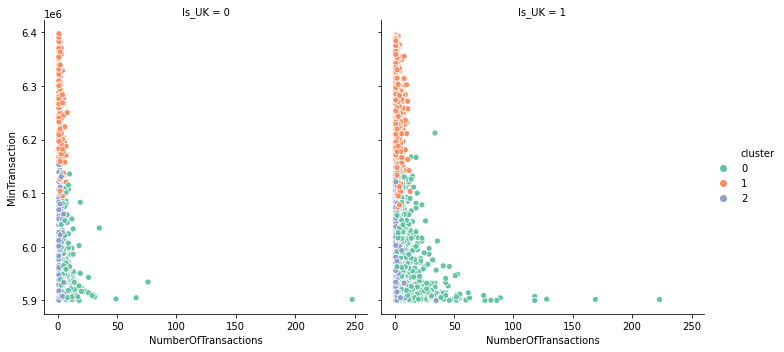

In [484]:
sns.relplot(data=df, x='NumberOfTransactions', y='MinTransaction', hue='cluster',palette="Set2", col='Is_UK')

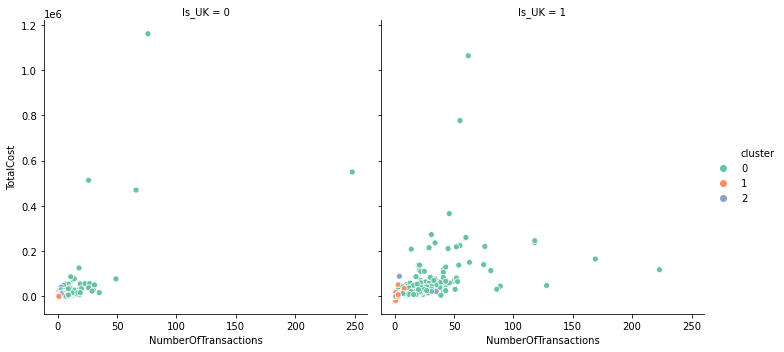

In [485]:
sns.relplot(data=df, x='NumberOfTransactions', y='TotalCost', hue='cluster',palette="Set2", col='Is_UK')

The final classification is based on <br/>
1. 'Is_UK' column tells whether the Usr is from UK
2. 'cluster' column containing 3 classes <br/>

From a total of 4370 'UserIds' 6 can be segmented easily. 

In [0]:
df.head()

,UserId,TotalCost,NumberOfTransactions,MaxTransaction,MinTransaction,GapTransaction,Is_UK,cluster
0,259266.0,0.00,2,5955763,5955741,22,1,2
1,259287.0,17879.70,7,6392980,5913886,479094,0,0
2,259308.0,7481.52,4,6249892,5932498,317394,0,0
3,259329.0,7285.92,1,6353699,6353699,0,0,1
4,259350.0,1387.20,1,5973407,5973407,0,0,2


In [0]:
temp=df.iloc[:,[0,6,7]]
temp=temp.sort_values(by=['Is_UK', 'cluster']).reset_index(drop=True)
temp=temp.groupby(['Is_UK', 'cluster'])['UserId'].unique().to_frame()
temp

UserId
Is_UK cluster                                                   
0     0        [259287.0, 259308.0, 259392.0, 259476.0, 25953...
      1        [259329.0, 259497.0, 259518.0, 259560.0, 25964...
      2        [259350.0, 259413.0, 259434.0, 259455.0, 25958...
1     0        [267687.0, 267708.0, 267729.0, 269220.0, 26928...
      1        [269262.0, 269304.0, 269367.0, 269388.0, 26943...
      2        [259266.0, 269241.0, 269409.0, 269451.0, 26951...

In [0]:
temp['UserId']=temp['UserId'].apply(lambda x:list(x))

In [0]:
df_final=temp

In [0]:
df_final.to_csv('data_final.csv')

In [0]:
df_final=pd.read_csv('data_final.csv')
df_final.set_index(['Is_UK', 'cluster'], inplace=True)
df_final["UserId"]=df_final["UserId"].apply(lambda x:list(x.strip('[]').split(',')))
df_final

UserId
Is_UK cluster                                                   
0     0        [259287.0,  259308.0,  259392.0,  259476.0,  2...
      1        [259329.0,  259497.0,  259518.0,  259560.0,  2...
      2        [259350.0,  259413.0,  259434.0,  259455.0,  2...
1     0        [267687.0,  267708.0,  267729.0,  269220.0,  2...
      1        [269262.0,  269304.0,  269367.0,  269388.0,  2...
      2        [259266.0,  269241.0,  269409.0,  269451.0,  2...

In [0]:
for i in range(6):
    print(len(df_final.iloc[i]['UserId']))

161
151
110
1577
1329
1042


###Analysis from cluster plots

By year I would be referring to Feb2018 to Feb2019. The analysis from the plots of clustering are given here.

1. Cluster0 -  Frequent customers who bought stuff throughout the year.
2. Cluster1 - Customers who were purchasing things during the beginning of the year but stopped purchasing in between.
3. Cluster2 - Customers who started purchasing late in the year.

Cluster1 requires more attention like asking then feedbacks of why they stopped purchasing.<br/>
Cluster0 can be given more benefits as they are the frequent customers.<br/>
Cluster3 are our new customers so should require more assist and clarifications on unfamiliar things.<br/>